<a href="https://colab.research.google.com/github/JyJumu/k_brazos_LAVC/blob/main/UCB_EML_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: Jesús Verdú Chacón
             Jorge López Abad
    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/JyJumu/k_brazos_LAVC.git
!cd k_brazos_LAVC/

fatal: destination path 'k_brazos_LAVC' already exists and is not an empty directory.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
#sys.path.append('/content/EML')
sys.path.append('/content/k_brazos_LAVC')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List
import matplotlib.pyplot as plt

from algorithms import Algorithm, EpsilonGreedy, UCB1, UCB2, Softmax, Gradiente
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics, plot_arm_num_choices


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_LAVC', '/content/k_brazos_LAVC']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_stats = [{'mean_rewards': np.zeros(bandit.k), 'selections': np.zeros(bandit.k)} for _ in algorithms]

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.
    optimal_reward = bandit.pull_arm(optimal_arm)

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for idx, algo in enumerate(algorithms):
            if isinstance(algo,UCB1):
                for step in range(steps):
                    chosen_arm = algo.select_arm(step) # Seleccionar un brazo según la política del algoritmo.
                    reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                    arm_stats[idx]['mean_rewards'][chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                    arm_stats[idx]['selections'][chosen_arm] += 1 # Actualizar el número de selecciones del brazo seleccionado por el algoritmo.
                    algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                    rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                    total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                    # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                    if chosen_arm == optimal_arm:
                        optimal_selections[idx, step] += 1

                    #regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]
                    regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - reward) if step > 0 else optimal_reward - reward

            elif isinstance(algo,UCB2):
                step = 0
                while step < steps:
                    chosen_arm, num_veces = algo.select_arm(step) # Seleccionar un brazo según la política del algoritmo.

                    i = 0
                    while (step < steps) and (i < num_veces):
                        reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                        arm_stats[idx]['mean_rewards'][chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                        arm_stats[idx]['selections'][chosen_arm] += 1 # Actualizar el número de selecciones del brazo seleccionado por el algoritmo.
                        algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                        rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                        total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                        #regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]
                        regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - reward) if step > 0 else optimal_reward - reward

                        if chosen_arm == optimal_arm:
                            optimal_selections[idx, step] += 1

                        step += 1
                        i += 1


                    # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm



    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100
    regret_accumulated /= runs
    for stat in arm_stats:
        stat['mean_rewards'] /= runs
        stat['selections'] /= runs

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 4 algoritmos UCB: dos de tipo UCB1 y otros dos de tipo UCB2.

A diferencia de los algoritmos ε-Greedy, donde se selecciona a los algoritmos de manera aleatoria con probabilidad ε y, en el resto de casos, se selecciona al brazo con mayor recompensa promedio; en los algoritmos UCB se selecciona al brazo con mayor límite superior de confianza. El límite superior de confianza se calcula según una cierta fórmula:

$$ ucb(a) = Q(a) + u(a) $$

donde $ucb(a)$ es el límite superior de confianza de la acción $a$, $Q(a)$ es el promedio de los valores de $a$ y $u(a)$ es el término de exploración de $a$.

El valor $u(a)$ se calcula de forma diferente según el algoritmo UCB que utilicemos. Para UCB1 tenemos la fórmula $u(a) = c \sqrt{\frac{\log{t}}{N(a)}}$, donde $c$ es el parámetro que ajusta la exploración, $t$ es el paso de tiempo en el que nos hallamos y $N(a)$ es el número de veces que se ha elegido la acción $a$.

Para UCB2 la fórmula es $u(a) = \sqrt{\frac{(1 + \alpha)\log{\frac{e\cdot t}{\tau(k_a)}}}{2\tau(k_a)}}$, donde $\alpha \in (0,1)$ es el parámetro de ajuste entre exploración y explotación, $k_a$ es el número de épocas de la acción $a$ y $\tau(k_a) = \lceil (1+\alpha)^{k_a} \rceil$ determina el número de veces que se ejecuta la acción $a$ en una época. En concreto, cuando se selecciona una acción $a$, esta se ejecuta $\lceil \tau(k_a+1) - \tau(k_a) \rceil$.

En este notebook y en los otros que utilizamos este tipo de algoritmos tomamos valores c = 0.1 y c = 1 para UCB1 y α = 0.1 y α = 0.9 para el gradiente de preferencias.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 2000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definimos un algoritmo UCB
algorithms = [UCB1(k=k, c=0.1), UCB1(k=k, c=1), UCB2(k=k, alfa=0.1), UCB2(k=k, alfa=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.37), ArmBernoulli(p=0.95), ArmBernoulli(p=0.6), ArmBernoulli(p=0.73), ArmBernoulli(p=0.16), ArmBernoulli(p=0.06), ArmBernoulli(p=0.87), ArmBernoulli(p=0.71), ArmBernoulli(p=0.97), ArmBernoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


## Visualización de los resultados

### Recompensa promedio vs pasos de tiempo

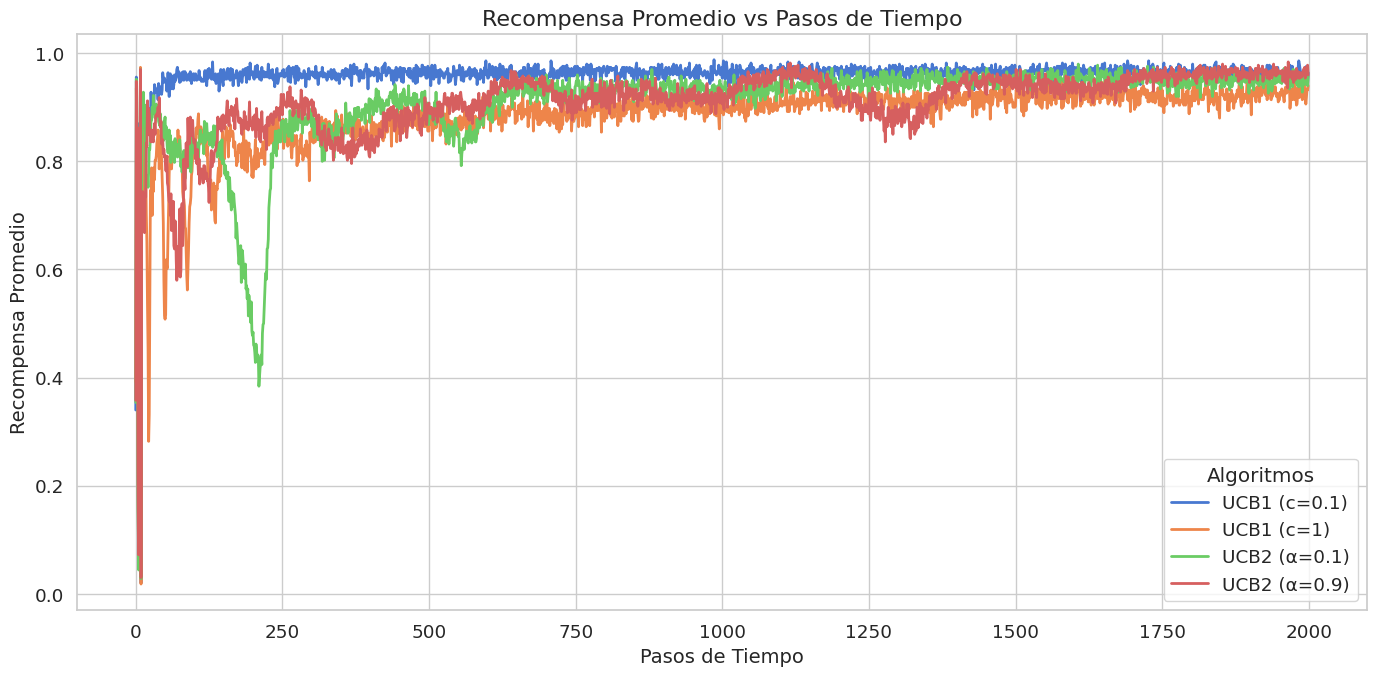

In [ ]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias de los algoritmos **UCB1 y UCB2** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **En todas las gráficas de esta sección, las cuatro líneas de colores distintos representan diferentes valores de c y α en los algoritmos UCB1 y UCB2:**
   - **Azul (UCB1 con c = 0):** Representa una estrategia **explotadora**, es decir, que se elige la acción que ha dado la mejor recompensa hasta ahora sin apenas explorar nuevas opciones.
   - **Naranja (UCB1 con c = 0.01):** Representa una estrategia **exploradora**, es decir, procura elegir opciones distintas de la que más beneficio devuelve.
   - **Verde (UCB2 con α = 0.1):** Representa una estrategia explotadora del algortimo UCB2.
   - **Roja (UCB2 con α = 0.9):** Representa una estrategia exploradora del algortimo UCB2.

2. **Crecimiento de la recompensa promedio:**
   En este caso, todos los modelos ofrecen un crecimiento similar. Solamente destaca la linea roja por la caída en la recompensa promedio en los primeros pasos, seguramente debido a que ha explorado una acción con una recompensa muy baja. La reomcpoensa promedio de los cuatro modelo es algo superior a 9.
   - La línea **azul (UCB1 con c=0.1)** tiene un gran crecimiento inicial y logra alcanzar muy tempranamente una recompensa promedio prácticamente perfecta con la que se mantiene hasta el final.
   - La línea **naranja (UCB1 con c=1)** muestra un buen crecimiento inicial y contiene varias oscilaciones seguramente debidas a exploraciones que han resultado infructuosas. Conforme avanza el tiempo, consigue mejorar la recompensa promedia hasta situarse alrededor de lo 0.9 puntos.
   - La línea **verde (UCB2 con α=0.1)** tiene un buen crecimiento inicial, similar al de la línea azul. Sin embargo, se estanca un poco antes y tiene un notable decrecimiento del cual se recupera un poco después. Consigue volver a crecer hasta alcanzar una recompensa promedio algo inferior a la línea azul.
   - La línea **roja (UCB2 con α=0.9)** presenta grandes oscilaciones en los primeros pasos de tiempo. Conforme avanza y llega hasta los últimos pasos de tiempo, logra situarse al mismo nivel que el resto de modelos.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

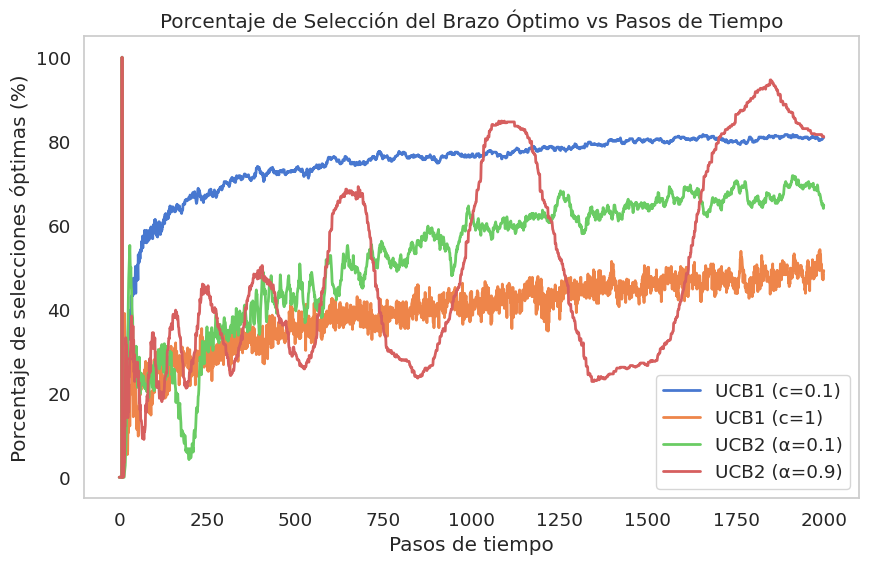

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo"**. Al igual que en la imagen anterior y en las venideras, en la gráfica se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestran es este caso el porcentaje promedio de selección del brazo óptimo la **recompensa promedio** obtenida por cada algoritmo.

* **Crecimiento del porcentaje de selección del brazo óptimo:**
   - La línea **azul (UCB1 con c=0.1)** presenta los mejores resultados con un buen crecimiento inicial. Tras reducirse este crecimiento inicial al alcanzar un 60% de selecciones óptimas, la línea sigue creciendo hasta lograr casi un 80% en los últimos pasos de tiempo.
   - La línea **naranja (UCB 1 con c=1)** muestra un crecimiento inicial muy reducido. Después sigue creciendo hasta lograr casi un 40% de selecciones óptimas.
   - La línea **verde (UCB2 con α=0.1)** tiene grandes oscilaciones, en particular alrededor del paso de tiempo 200. Logra alcanzar en torno a un 50% de selecciones óptimas.
   - La línea **roja (UCB2 con α=0.9)** consigue acertar siempre en los primeros pasos de tiempo. Sin embargo, después explora otras opciones y presenta grandes oscilaciones sin llegar a estabilizarse.

Los modelos explotadores son los que consiguen el mayor número de selecciones óptimas.

---





### Arrepentimiento acumulado vs pasos de tiempo

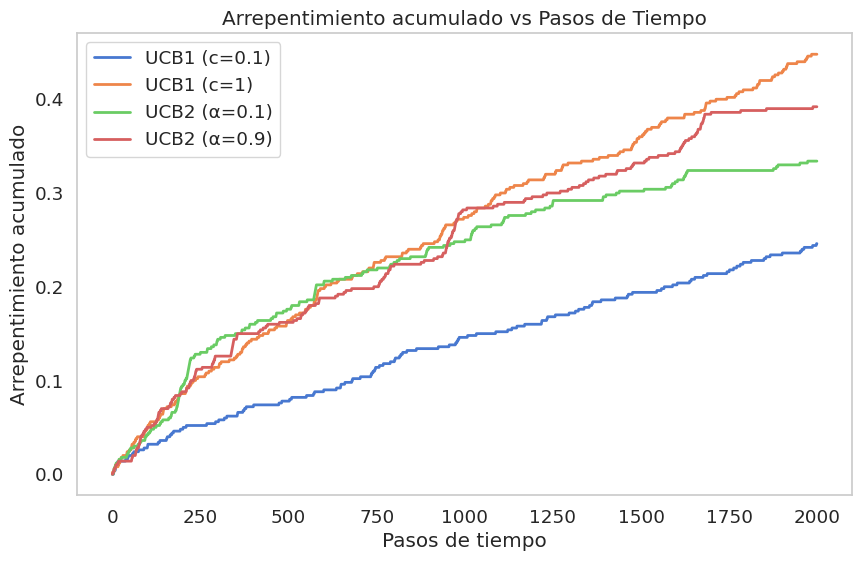

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Arrepentimiento acumulado vs Pasos de Tiempo"**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el arrepentimiento acumulado de cada algoritmo.

* **Crecimiento del arrepentimiento acumulado:**
   - La línea **azul (UCB1 con c=0.1)** presenta, con diferencia, el menor crecimiento y, por ende, el menor arrepentimiento acumulado.
   - La línea **naranja (UCB 1 con c=1)** muestra un gran crecimiento a lo largo del tiempo, siendo este el modelo con el mayor arrepentimiento acumulado.
   - La línea **verde (UCB2 con α=0.1)** se asemeja a la línea naranja. Este modelo es el segundo con el mayor arrepentimiento acumulado
   - La línea **roja (UCB2 con α=0.9)** tiene un crecimiento inciial similar al de las líneas naranja y verde, aunque al superar el paso de tiempo 400 comienza a separarse y logra un arrepentimiento acumulado menor.

---





### Ganancia promedio y número de selecciones por brazo

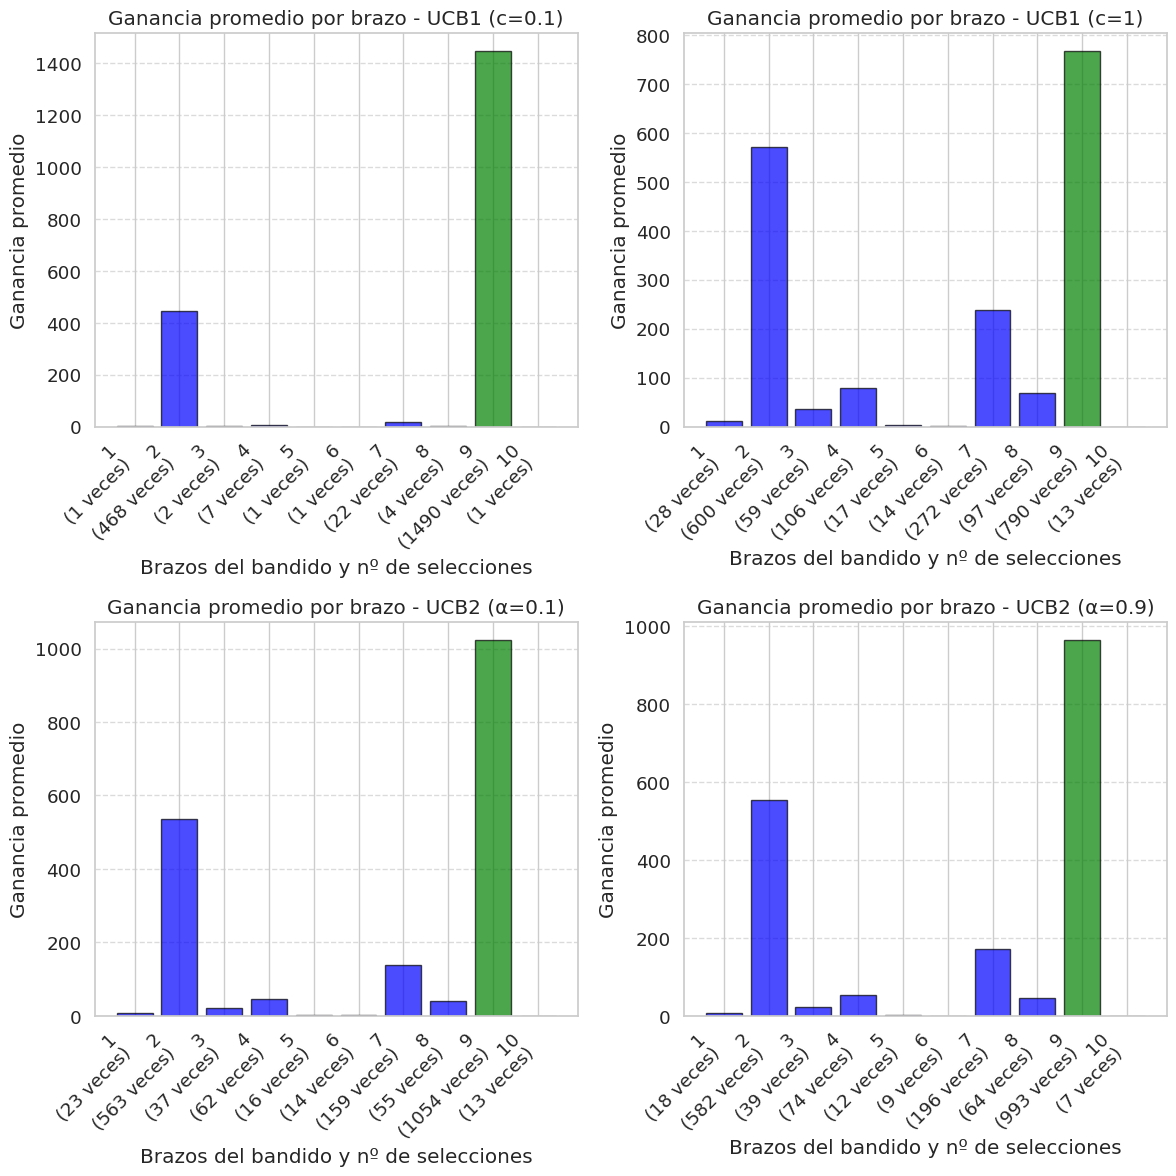

In [ ]:
plot_arm_statistics(arm_stats, algorithms, k, optimal_arm)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra tres gráficos de barras, cada uno titulado **"Ganancia promedio por brazo"**. En el eje **x** se representan los **brazos del bandido**, indicando en paréntesis el número de selecciones por brazo; mientras que en el eje **y** se muestra la ganancia obtenida de cada brazo. Además, la barra del brazo óptimo se muestra en verde y la del resto de brazos en azul.

1. **Las cuatro gráficas que se muestran se corresponden a diferentes valores c y α de los algoritmos UCB1 y UCB2. De izquierda a derecha y de arriba a abajo tenemos:**
   - **Primera gráfica (UCB1 con c=0.1):** Representa los resultados de la estrategia **explotadora** del algoritmo UCB1.
   - **Segunda gráfica (UCB1 con c=1):** Representa una estrategia exploradora del algoritmo UCB1.
   - **Tercera gráfica (UCB2 con α=0.1):** Representa una estrategia explotadora de UCB2.
   - **Cuarta gráfica (UCB2 con α=0.9):** Representa una estrategia exploradora de UCB2.

2. **Ganancia y número de selecciones promedio por brazo:**
   - La **primera gráfica (CB1 con c=0.1)** se corresponde con la estrategia más explotadora. En ella podemos ver que prácticamente los únicos brazos que se seleccionan son los brazos dos y nueve, siendo este último el brazo óptimo. Además, el número de selecciones del brazo óptimo es algo más de tres veces mayor que las del segundo brazo. La ganancia lograda es alta.
   - La **segunda gráfica (UCB1 con c=1)** muestra que la estrategia exploradora no obtiene un mejor rendimiento que la explotadora, pues el brazo óptimo, aunque se selecciona más veces que el resto, no se selecciona de manera mayoritaria.
   - La **tercera gráfica (UCB2 con α=0.1)** presenta una selección casi maoyritaria del brazo óptimo para la estrategia explotadora de UCB2. Esta estrategia no supera a la explotadora de UCB1.
   - La **cuarta gráfica (UCB2 con α=0.9)** muestra que, nuevamente, la estrategia exploradora no mejora el rendimiento de la explotadora para las distribuciones de tipo Bernoulli, pues el número de selecciones óptimas se ha reducido.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **UCB1** equilibra la exploración y la explotación:
- **Explotación (valores bajos de c)**: Favorece más las acciones con mayor recompensa estimada.
- **Exploración (valores altos de c)**: Favorece aquellas acciones con mayor recompensa estimada o que hayan sido elegidas en pocas ocasiones.

Por otro lado, **UCB2** también equilibra entre la exploración y la explotación (recordemos que $\alpha \in (0,1)$):
- **Explotación (valores bajos de α)**: Favorece más las acciones con mayor recompensa estimada.
- **Exploración (valores altos de α)**: Al igual que con UCB1, se favorecen más las acciones con mayor recompensa estimada o que hayan sido elegidas en pocas ocasiones.

Los gráficos de línea y de barras confirman este comportamiento:
- **UCB1 con c=0.1 (azul en los gráficos de línea y el primero en los de barras)**: Es el modelo que mejor rendimiento ofrece. Logra la mayor recompensa promedio, el menor arrepentimiento y el mayor número promedio de selecciones óptimas.
- **UCB1 con c=1 (naranja en los gráficos de línea y el segundo en los de barras)**: La estrategia exploradora de UCB1 ofrece un rendimiento peor, pues no consigue centrarse en el brazo óptimo y las penalizaciones por no elegirlo le hacen tener una ganancia claramente peor.
- **UCB2 con α=0.1 (verde en los gráficos de línea y el tercero en los de barras)**: Esta estrategia explotadora no es capaz de encontrar el brazo óptimo a tiempo y se ve gravemente penalizada por ello, logrando una ganancia mucho menor que la estrategia explotadora de UCB1 y una recompensa promedio claramente inferior.
- **UCB2 con α=0.9 (rojo en los gráficos de línea y el cuarto en los de barras)**: Al igual que con la estrategia exploradora de UCB1, las penalizaciones por explorar le hacen tener una ganancia reducida.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor explotación alcanzan, en ambos algoritmos, una recompensa más alta, pues logran centrarse en el brazo óptimo un mayor número de veces.

Además, dado que estamos trabajando con una distribución Bernouilli, los fallos penalizan gravemente, lo cual da lugar a que las estrategias exploradoras vean tengan un rendimiento inferior al esperado en otras estrategias.


#### **3. Aplicaciones y conclusiones**
En las distribuciones de Bernouilli, dado que solo podemos tener como posibles ganancias acierto o fallo, ello supone que los falloss penalizan mucho más que en otras distribuciones. Es por ello que las estrategias exploradoras, al seleccionar nuevos brazos para estudiar el rendimiento, se vean claramente perjudicados cuando no obtienen un buen resultado.

En conclusión, **los gráficos muestran que el rendimiento ofrecido por ambas estrategias en UCB2 es similar y que se asemejan al ofrecido por la estrategia exploradora de UCB1. La estrategia explotadora de UCB1, por otro lado, ofrece un rendimiento mucho mejor que los otroso modelos. Además, en base a los resultados vistos podemos afirmar que la mejor estrategia para las distribuciones Bernouilli es la explotadora**. 🚀